# Random forest rift identifier

This notebook employs the Random Forest algorithm, an ensemble machine learning method, to classify ICESat-2 tracks based on whether they pass over rifts or not. We start by selecting the number of decision trees to include in our forest:

In [1]:
trees = 50 #choose the number of decision trees

We then import all necessary packages and modules: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

and set paths as necessary.

In [3]:
root_path = '/data/fast1/rift-id/'
outputs_path = root_path + 'outputs' #where the training data are stored
area_path = root_path + 'area'
shapefiles_path = root_path + 'shapefiles'
sliderule_path = root_path + 'sliderule'

## Step 1: load training data (rifted ice)

The first dataset consists of ICESat-2 tracks, each representing a series of surface elevation measurements along a linear profile. These profiles have been manually labeled to indicate which coordinates fall within rifts, and which do not (see the plot a few cells down). 

In [27]:
training_data = pd.read_pickle(outputs_path + '/dml_all_bin_lr.pkl') #load the training data with rifted ice
display(training_data.head()) #and display some of its contents below

,shelf,rift,trace_nr,rgt,beam,cycle,x_subset,y_subset,d_subset,h_subset,coords,rift_width,bin_subset
0,dml,F3a,251.0,854.0,3l,8.0,"[-35051.9507797757, -35054.69159288903, -35057...","[2209801.822420919, 2209821.6137664495, 220984...","[2210079.802547474, 2210099.6348744165, 221011...","[37.8853027194217, 37.80916926938781, 37.71423...","[[2214751.7884001248, 36.35006877579091], [221...",624.383781,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,dml,F3a,257.0,907.0,1l,8.0,"[-36176.617142950425, -36178.70181675851, -361...","[2219700.378208351, 2219680.5043959934, 221966...","[2219995.1614015293, 2219975.324200879, 221995...","[35.95811775961225, 35.95619088014532, 35.9472...","[[2214687.1412469666, 34.79023383768912], [221...",641.490186,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,dml,F3a,318.0,1296.0,1r,4.0,"[-31740.226040771147, -31743.018613824494, -31...","[2209875.7924229424, 2209895.5737409526, 22099...","[2210103.721522148, 2210123.5409068363, 221014...","[39.874198151842805, 39.8879744656365, 39.8297...","[[2214744.7319527855, 39.209766162310856], [22...",667.149793,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,dml,F3a,258.0,907.0,1r,8.0,"[-36268.06361407608, -36270.205783219826, -362...","[2219669.882548686, 2219650.0148718944, 221963...","[2219966.1618889626, 2219946.331862182, 221992...","[36.04938743890687, 36.05862249905419, 36.0207...","[[2214654.730072184, 34.98521320495185], [2215...",675.702995,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,dml,F3a,235.0,854.0,3l,3.0,"[-34920.31000628142, -34923.13998048323, -3492...","[2208892.2175512146, 2208911.9957032157, 22089...","[2209168.227367318, 2209188.04778309, 2209207....","[37.48623879428231, 37.424937917146465, 37.330...","[[2213817.998200497, 35.83012379642365], [2214...",675.702995,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


While there is a lot of info contained in this dataset, the crucial piece of information is ```h_subset```, which records the elevation profile along a given track. We'll save these data to a separate array, and also nondimensionalize the result by dividing each elevation profile by its maximal value:

In [5]:
heights = training_data['h_subset'] #surface elevations along each track
scaled_heights = [] #initialize list for normalized surface elevations

for height_data in heights: #for each track:
    scaled_data = height_data/np.max(height_data) #normalize the elevations to their max value
    scaled_heights.append(scaled_data) #and append to the list

heights_1 = np.array(scaled_heights, dtype=object)  #'1' indicates rifted ice

## Plot an example rift

Text(0.5, 1.0, 'rift F3a')

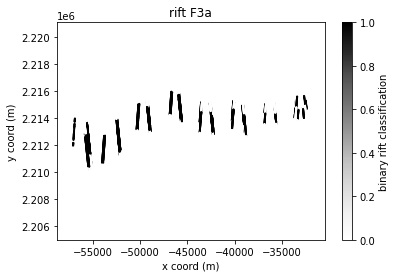

In [6]:
chosen_rift = 'F3a' #we arbitrarily choose this rift name from the table above

rift_names = training_data['rift'] #the names of each rift
x, y = training_data['x_subset'], training_data['y_subset'] #x and y coordinates along each track
binary = training_data['bin_subset'] #classifies each (x, y) coordinate as "rift" (1) or "non-rift" (0)
plt.figure()

for i in range(len(heights)):
    if rift_names[i] == chosen_rift:
        plt.scatter(x[i], y[i], s = 1, c = binary[i], cmap = 'Greys')
cbar = plt.colorbar()
cbar.set_label('binary rift classification')
plt.xlabel('x coord (m)')
plt.ylabel('y coord (m)')
plt.title(f'rift {chosen_rift}')

## Step 2: Load training data (non-rifted ice)

Similar to the rifted-ice data, except that these tracks have been manually-verified to not pass over any rifts. 

In [28]:
training_data = pd.read_pickle(outputs_path + '/dml_all_bin_lr_nonrift.pkl') #load the non-rift training data
display(training_data.head()) #and display

,shelf,trace_nr,rgt,beam,cycle,x_subset,y_subset,d_subset,h_subset
0,dml,3,343,1l,1,"[7189.130619388052, 7186.582485923817, 7184.05...","[2178538.164580444, 2178518.367937365, 2178498...","[2178550.0265388885, 2178530.221596273, 217851...","[48.61846717820136, 48.629136266546986, 48.685..."
1,dml,3,343,1l,1,"[10771.061710737451, 10768.46265320321, 10765....","[2206342.992558727, 2206323.1867494155, 220630...","[2206369.283819773, 2206349.4655597988, 220632...","[39.312748235934464, 39.36207013152795, 39.436..."
2,dml,4,343,1r,1,"[1545.5180160965535, 1542.9408661270236, 1540....","[2135298.5680844295, 2135278.7991766883, 21352...","[2135299.1274033138, 2135279.356636962, 213525...","[61.566919891431056, 61.65171745137367, 61.668..."
3,dml,4,343,1r,1,"[4613.970076180094, 4611.471113110717, 4608.96...","[2159313.6893266398, 2159293.8971956973, 21592...","[2159318.618831711, 2159298.821407637, 2159279...","[54.380458381895046, 54.431472361310135, 54.38..."
4,dml,4,343,1r,1,"[11211.057107959065, 11208.581233071916, 11206...","[2210596.637684287, 2210576.8136304324, 221055...","[2210625.0659807855, 2210605.229626885, 221058...","[37.515234850604074, 37.533068170604736, 37.57..."


In [8]:
heights = training_data['h_subset'] #surface elevations along each track
scaled_heights = [] #initialize list for normalized surface elevations

for height_data in heights: #for each track:
    scaled_data = height_data/np.max(height_data) #then normalize the elevations to their max value
    scaled_heights.append(scaled_data) #and append to the list

heights_0 = np.array(scaled_heights, dtype=object)  #where '0' indicates non-rifted ice

## Plot an example non-rift

Text(0.5, 0, 'distance along track (m)')

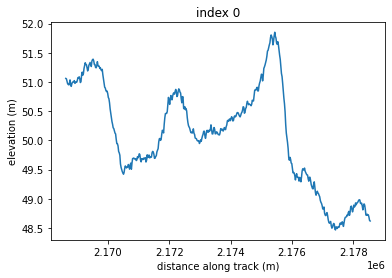

In [9]:
index = 0

dist = training_data['d_subset']

plt.figure()
plt.plot(dist[index], heights[index])
plt.title(f'index {index}')
plt.ylabel('elevation (m)')
plt.xlabel('distance along track (m)')

## Concatenate all relevant data together

Next, we compile all the data into two lists for training the rift classification model. The first list contains all surface elevation profiles, including those with and without rifts. The second list consists of binary labels, where ```1``` indicates profiles that contain rifts and ```0``` indicates profiles without rifts.

In [10]:
heights = np.concatenate([heights_0, heights_1]) #concatenate all surface elevation profiles together
labels = np.concatenate([np.zeros(len(heights_0)), np.ones(len(heights_1))]) #label each profile in 'heights'

In [11]:
rift_data = {
    'features': heights,
    'labels': labels
}

## Define and train the model

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(rift_data['features'], rift_data['labels'], test_size = 0.2, random_state=0)
model = RandomForestClassifier(n_estimators = trees)

score = 1
while score == 1: #temporarily tweaking this to avoid getting a 'perfect' model
    model.fit(X_train, Y_train)
    score = model.score(X_test,Y_test)

## Investigate model performance

We first display the confusion matrix, and then we specifically examine one example from each quadrant (where applicable). 

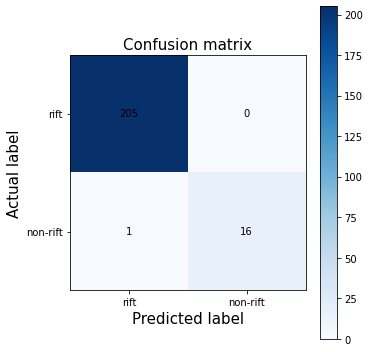

In [13]:
Y_predicted = model.predict(X_test)
cm = metrics.confusion_matrix(Y_test, Y_predicted)

plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['rift', 'non-rift'], size=10)
plt.yticks(tick_marks, ['rift', 'non-rift'], size=10)
plt.tight_layout()
plt.ylabel('Actual label', size=15)
plt.xlabel('Predicted label', size=15)
width, height = cm.shape

for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x),
                     horizontalalignment='center',
                     verticalalignment='center')

plt.show()

## Investigate where data are correctly/incorrectly classified

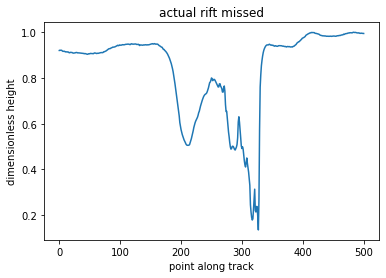

<Figure size 432x288 with 0 Axes>

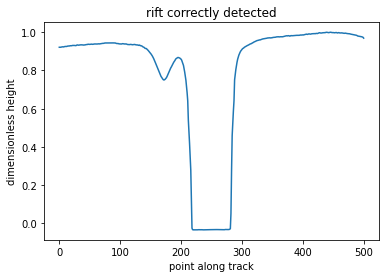

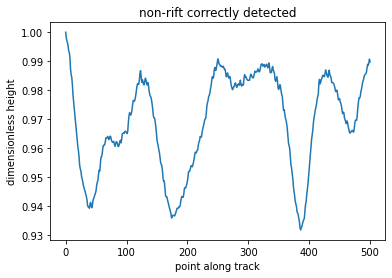

In [14]:
false_positive_indices = np.where((Y_test == 0) & (Y_predicted != 0))[0] #actually no rift, but rift predicted
false_negative_indices = np.where((Y_test == 1) & (Y_predicted != 1))[0] #actually a rift, but none predicted
true_positive_indices = np.where((Y_test == 1) & (Y_predicted == 1))[0] #actually a rift, and rift predicted
true_negative_indices = np.where((Y_test == 0) & (Y_predicted == 0))[0] #actually no rift, and none predicted

try:
    plt.figure()
    plt.plot(X_test[false_negative_indices[0]]) #plot the data corresponding to the false negative
    plt.title('actual rift missed')
    plt.ylabel('dimensionless height')
    plt.xlabel('point along track')
except:
    pass

try:
    plt.figure()
    plt.plot(X_test[false_positive_indices[0]]) #etc.
    plt.title('rift incorrectly predicted')
    plt.ylabel('dimensionless height')
    plt.xlabel('point along track')
except:
    pass

try:
    plt.figure()
    plt.plot(X_test[true_positive_indices[0]])
    plt.title('rift correctly detected')
    plt.ylabel('dimensionless height')
    plt.xlabel('point along track')
except:
    pass

try:
    plt.figure()
    plt.plot(X_test[true_negative_indices[0]])
    plt.title('non-rift correctly detected')
    plt.ylabel('dimensionless height')
    plt.xlabel('point along track')
except:
    pass

### new stuff

Haven't looked much at this part of the notebook yet

In [15]:
# load study shelf shapefiles
all_shelf_outline_path = shapefiles_path + '/USNIC_ANTARC_shelf_2022_epsg3031.shp'
all_shelf_outline = gpd.read_file(all_shelf_outline_path)
study_shelf_outline = all_shelf_outline[all_shelf_outline['OBJECTID']==591009]
study_area_outline_path = area_path + '/box_dml_test.shp'    
study_area_outline = gpd.read_file(study_area_outline_path)

# define study area bounding box in polar stereographic
study_area_xmin = study_area_outline.bounds.minx[0]
study_area_xmax = study_area_outline.bounds.maxx[0]
study_area_ymin = study_area_outline.bounds.miny[0]
study_area_ymax = study_area_outline.bounds.maxy[0]

# calculate of study area center and buffer for plot
distbuffer = 1.1*(np.max([study_area_xmax-study_area_xmin, study_area_ymax-study_area_ymin])/2)
centerx = np.mean([study_area_xmax,study_area_xmin])
centery = np.mean([study_area_ymax,study_area_ymin])

In [16]:
# load pickle
pickle_path = sliderule_path + '/sliderule_study_area_dml_cycle11.pkl'
atl06_data = pd.read_pickle(pickle_path)
display(atl06_data)

,time,x,y,x_atc,lat,lon,h,geoid,tides,quality,h_sig,cycle,rgt,beam
0,2021-03-26 08:37:40.866860800,"[-50307.758468295266, -50417.17602568305, -504...","[2280552.5910639, 2279436.966040412, 2279018.6...","[27792025.250218205, 27793140.25905701, 277935...","[-69.22685300342985, -69.23677604872877, -69.2...","[-1.2637089961745078, -1.2670762633495432, -1....","[7.756271788845216, 7.846335847787395, 7.82124...","[9.930870594039048, 9.96271925853081, 9.974860...","[-0.40758735, -0.4081091, -0.40830496, -0.4083...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.04945055964167696, 0.05993237956888113, 0.0...",11,23,1l
1,2021-03-26 08:37:41.037712896,"[-50270.37389738817, -50272.28099091074, -5027...","[2281896.599394636, 2281876.6715516583, 228185...","[27790691.220701646, 27790711.13159864, 277907...","[-69.21488036232438, -69.21505761399084, -69.2...","[-1.2620267010818258, -1.2620855810116396, -1....","[7.827887620301715, 7.764304595789732, 7.53754...","[9.900398279187032, 9.900977043541143, 9.90155...","[-0.40696156, -0.40697244, -0.40698165, -0.406...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.022528522187709298, 0.03790892993093624, 0....",11,23,1r
2,2021-03-26 08:37:40.908867072,"[-53711.1639973591, -53713.11004549511, -53732...","[2280464.935684791, 2280445.0114185195, 228024...","[27792443.37862945, 27792463.28950328, 2779266...","[-69.22694247001449, -69.227119656176, -69.228...","[-1.349222302779825, -1.3492829535957724, -1.3...","[7.741097769470653, 7.571254694051456, 7.64603...","[9.908589646330592, 9.908968671174659, 9.91275...","[-0.40531406, -0.40532398, -0.40542534, -0.405...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.04506707100265365, 0.032580432003668294, 0....",11,23,2l
3,2021-03-26 08:37:40.956063232,"[-53589.613995411084, -53591.62877258, -53593....","[2282685.8798110597, 2282665.960965646, 228264...","[27790233.269998103, 27790253.180901155, 27790...","[-69.20717217613138, -69.20734929044116, -69.2...","[-1.3448608185499442, -1.344923093484284, -1.3...","[8.17014113138064, 7.544810781911221, 7.496389...","[9.843527465714098, 9.84410488330482, 9.844682...","[-0.4042947, -0.40430394, -0.40431347, -0.4043...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.05014263284345887, 0.0720250625494654, 0.04...",11,23,2r
4,2021-03-26 08:37:40.748591616,"[-56979.40999984719, -57079.34103105208, -5725...","[2281812.053972535, 2280795.889419774, 2279002...","[27791427.923715092, 27792443.37862945, 277942...","[-69.21422862591847, -69.22326338248112, -69.2...","[-1.4304426996636184, -1.4335885356099416, -1....","[8.45054137761454, 7.198120860542157, 8.536495...","[9.835844280825482, 9.865329907096257, 9.90736...","[-0.40238, -0.4028587, -0.40368843, -0.4038725...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.037006679403575965, 0.0386426366109769, 0.0...",11,23,3l
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2021-06-21 17:10:23.621510656,"[-27705.687082902128, -27722.773092419804, -27...","[1980397.4283239353, 1980515.3219632423, 19806...","[32119411.161456596, 32119530.605531752, 32119...","[-71.91686256593705, -71.91580122752377, -71.9...","[-0.801513557379469, -0.8019600490284113, -0.8...","[221.95405743901227, 219.94191056138416, 216.7...","[10.743829387512937, 10.743316807227407, 10.74...","[3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.05615161721348499, 0.09234015933423258, 0.0...",11,1357,1r
376,2021-06-21 17:10:31.826208000,"[-33262.65410015448, -33265.520534259165, -332...","[2040735.082718131, 2040754.7616163464, 204083...","[32180030.12571454, 32180050.033784337, 321801...","[-71.37442087432981, -71.37424392022105, -71.3...","[-0.9338012400493081, -0.9338726930382525, -0....","[260.6444024704661, 260.45351921299726, 259.42...","[11.794150226722147, 11.794880053968672, 11.79...","[3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","

In [17]:
atl06_data_sub = atl06_data
display(atl06_data_sub)
print(len(atl06_data_sub["h"].iloc[0]))

,time,x,y,x_atc,lat,lon,h,geoid,tides,quality,h_sig,cycle,rgt,beam
0,2021-03-26 08:37:40.866860800,"[-50307.758468295266, -50417.17602568305, -504...","[2280552.5910639, 2279436.966040412, 2279018.6...","[27792025.250218205, 27793140.25905701, 277935...","[-69.22685300342985, -69.23677604872877, -69.2...","[-1.2637089961745078, -1.2670762633495432, -1....","[7.756271788845216, 7.846335847787395, 7.82124...","[9.930870594039048, 9.96271925853081, 9.974860...","[-0.40758735, -0.4081091, -0.40830496, -0.4083...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.04945055964167696, 0.05993237956888113, 0.0...",11,23,1l
1,2021-03-26 08:37:41.037712896,"[-50270.37389738817, -50272.28099091074, -5027...","[2281896.599394636, 2281876.6715516583, 228185...","[27790691.220701646, 27790711.13159864, 277907...","[-69.21488036232438, -69.21505761399084, -69.2...","[-1.2620267010818258, -1.2620855810116396, -1....","[7.827887620301715, 7.764304595789732, 7.53754...","[9.900398279187032, 9.900977043541143, 9.90155...","[-0.40696156, -0.40697244, -0.40698165, -0.406...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.022528522187709298, 0.03790892993093624, 0....",11,23,1r
2,2021-03-26 08:37:40.908867072,"[-53711.1639973591, -53713.11004549511, -53732...","[2280464.935684791, 2280445.0114185195, 228024...","[27792443.37862945, 27792463.28950328, 2779266...","[-69.22694247001449, -69.227119656176, -69.228...","[-1.349222302779825, -1.3492829535957724, -1.3...","[7.741097769470653, 7.571254694051456, 7.64603...","[9.908589646330592, 9.908968671174659, 9.91275...","[-0.40531406, -0.40532398, -0.40542534, -0.405...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.04506707100265365, 0.032580432003668294, 0....",11,23,2l
3,2021-03-26 08:37:40.956063232,"[-53589.613995411084, -53591.62877258, -53593....","[2282685.8798110597, 2282665.960965646, 228264...","[27790233.269998103, 27790253.180901155, 27790...","[-69.20717217613138, -69.20734929044116, -69.2...","[-1.3448608185499442, -1.344923093484284, -1.3...","[8.17014113138064, 7.544810781911221, 7.496389...","[9.843527465714098, 9.84410488330482, 9.844682...","[-0.4042947, -0.40430394, -0.40431347, -0.4043...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.05014263284345887, 0.0720250625494654, 0.04...",11,23,2r
4,2021-03-26 08:37:40.748591616,"[-56979.40999984719, -57079.34103105208, -5725...","[2281812.053972535, 2280795.889419774, 2279002...","[27791427.923715092, 27792443.37862945, 277942...","[-69.21422862591847, -69.22326338248112, -69.2...","[-1.4304426996636184, -1.4335885356099416, -1....","[8.45054137761454, 7.198120860542157, 8.536495...","[9.835844280825482, 9.865329907096257, 9.90736...","[-0.40238, -0.4028587, -0.40368843, -0.4038725...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.037006679403575965, 0.0386426366109769, 0.0...",11,23,3l
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2021-06-21 17:10:23.621510656,"[-27705.687082902128, -27722.773092419804, -27...","[1980397.4283239353, 1980515.3219632423, 19806...","[32119411.161456596, 32119530.605531752, 32119...","[-71.91686256593705, -71.91580122752377, -71.9...","[-0.801513557379469, -0.8019600490284113, -0.8...","[221.95405743901227, 219.94191056138416, 216.7...","[10.743829387512937, 10.743316807227407, 10.74...","[3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.05615161721348499, 0.09234015933423258, 0.0...",11,1357,1r
376,2021-06-21 17:10:31.826208000,"[-33262.65410015448, -33265.520534259165, -332...","[2040735.082718131, 2040754.7616163464, 204083...","[32180030.12571454, 32180050.033784337, 321801...","[-71.37442087432981, -71.37424392022105, -71.3...","[-0.9338012400493081, -0.9338726930382525, -0....","[260.6444024704661, 260.45351921299726, 259.42...","[11.794150226722147, 11.794880053968672, 11.79...","[3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","

1265


In [18]:
bin_array = {
    "cycle": [],
    "rgt":   [],
    "beam":  [],
    "x_mid": [],
    "y_mid": [],
    "d_mid": [],
    "x_min": [],
    "y_min": [],
    "d_min": [],
    "bin":   []
}

for trace in range(121,122): #0,len(atl06_data_sub)):
    h_fb = atl06_data_sub["h"].iloc[trace] - atl06_data_sub["geoid"].iloc[trace]
    x = atl06_data_sub["x"].iloc[trace]
    y = atl06_data_sub["y"].iloc[trace]
    d = np.sqrt(x**2 + y**2)

    quality = atl06_data_sub["quality"].iloc[trace]
    
    #remove poor quality here if needed

    cycle = atl06_data_sub["cycle"].iloc[trace]
    rgt   = atl06_data_sub["rgt"].iloc[trace]
    beam  = atl06_data_sub["beam"].iloc[trace]
    
    if cycle < 10:
        cycle_str = '0'+str(cycle)
    else:
        cycle_str = str(cycle)

    if len(h_fb) >= 501:
        print("cycle: "+cycle_str+" rgt: "+str(rgt)+" beam: "+beam+" number_points: "+str(len(h_fb))+" (quality: "+str(np.sum(quality))+")")
        
        x_mid_trace = []
        y_mid_trace = []
        d_mid_trace = []
        x_min_trace = []
        y_min_trace = []
        d_min_trace = []
        bin_trace   = []
        
        n_tot = 0
        n_yes = 0
        
        
        for segment in range(251,len(h_fb)-250):
            n_tot += 1

            h_fb_sub = h_fb[segment-251:segment+250]
            h_fb_sub_scale = h_fb[segment-251:segment+250]
            x_sub    = x[segment-251:segment+250]
            y_sub    = y[segment-251:segment+250]
            d_sub    = d[segment-251:segment+250]
            
            d_sub_len = np.max(d_sub) - np.min(d_sub)
            d_sub_mid = np.mean((np.max(d_sub),np.min(d_sub)))
            x_sub_mid = np.mean((np.max(x_sub),np.min(x_sub)))
            y_sub_mid = np.mean((np.max(y_sub),np.min(y_sub)))
            
            trace_min_loc = np.where(h_fb_sub_scale == np.min(h_fb_sub_scale))
            d_sub_min = d_sub[trace_min_loc][0]
            x_sub_min = x_sub[trace_min_loc][0]
            y_sub_min = y_sub[trace_min_loc][0]
    
            if ((len(h_fb_sub_scale)==501) & (d_sub_len < 12000)):
                n_yes += 1
        
                # scale here
                if np.min(h_fb_sub_scale) < 0:
                    h_fb_sub_scale = h_fb_sub_scale - np.min(h_fb_sub_scale)
                    
                h_fb_sub_scale = h_fb_sub_scale / np.max(h_fb_sub_scale)
                
                seg_predict = model.predict(np.array([h_fb_sub_scale]))

                x_mid_trace.append(x_sub_mid)
                y_mid_trace.append(y_sub_mid)
                d_mid_trace.append(d_sub_mid)
                
                x_min_trace.append(x_sub_min)
                y_min_trace.append(y_sub_min)
                d_min_trace.append(d_sub_min)
                
                bin_trace.append(int(seg_predict[0]))
                
        print("processed segments: "+str(n_yes)+" of "+str(n_tot)+" ("+str(round(100*(n_yes/n_tot),1))+"%)")
        
        if len(bin_trace) > 0:
            bin_array["cycle"].append(cycle)
            bin_array["rgt"].append(rgt)
            bin_array["beam"].append(beam)
            bin_array["x_mid"].append(x_mid_trace)
            bin_array["y_mid"].append(y_mid_trace)
            bin_array["d_mid"].append(d_mid_trace)
            bin_array["x_min"].append(x_min_trace)
            bin_array["y_min"].append(y_min_trace)
            bin_array["d_min"].append(d_min_trace)
            bin_array["bin"].append(bin_trace)
        

cycle: 11 rgt: 465 beam: 2l number_points: 3517 (quality: 12)
processed segments: 1492 of 3016 (49.5%)


In [19]:
bin_array = pd.DataFrame(bin_array)
display(bin_array)

,cycle,rgt,beam,x_mid,y_mid,d_mid,x_min,y_min,d_min,bin
0,11,465,2l,"[-48751.634741703776, -48753.646899542255, -48...","[2228126.394239113, 2228106.506949217, 2228086...","[2228659.7766525075, 2228639.9381331727, 22286...","[-48317.16932364154, -48317.16932364154, -4831...","[2232401.813245448, 2232401.813245448, 2232401...","[2232924.6303073047, 2232924.6303073047, 22329...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


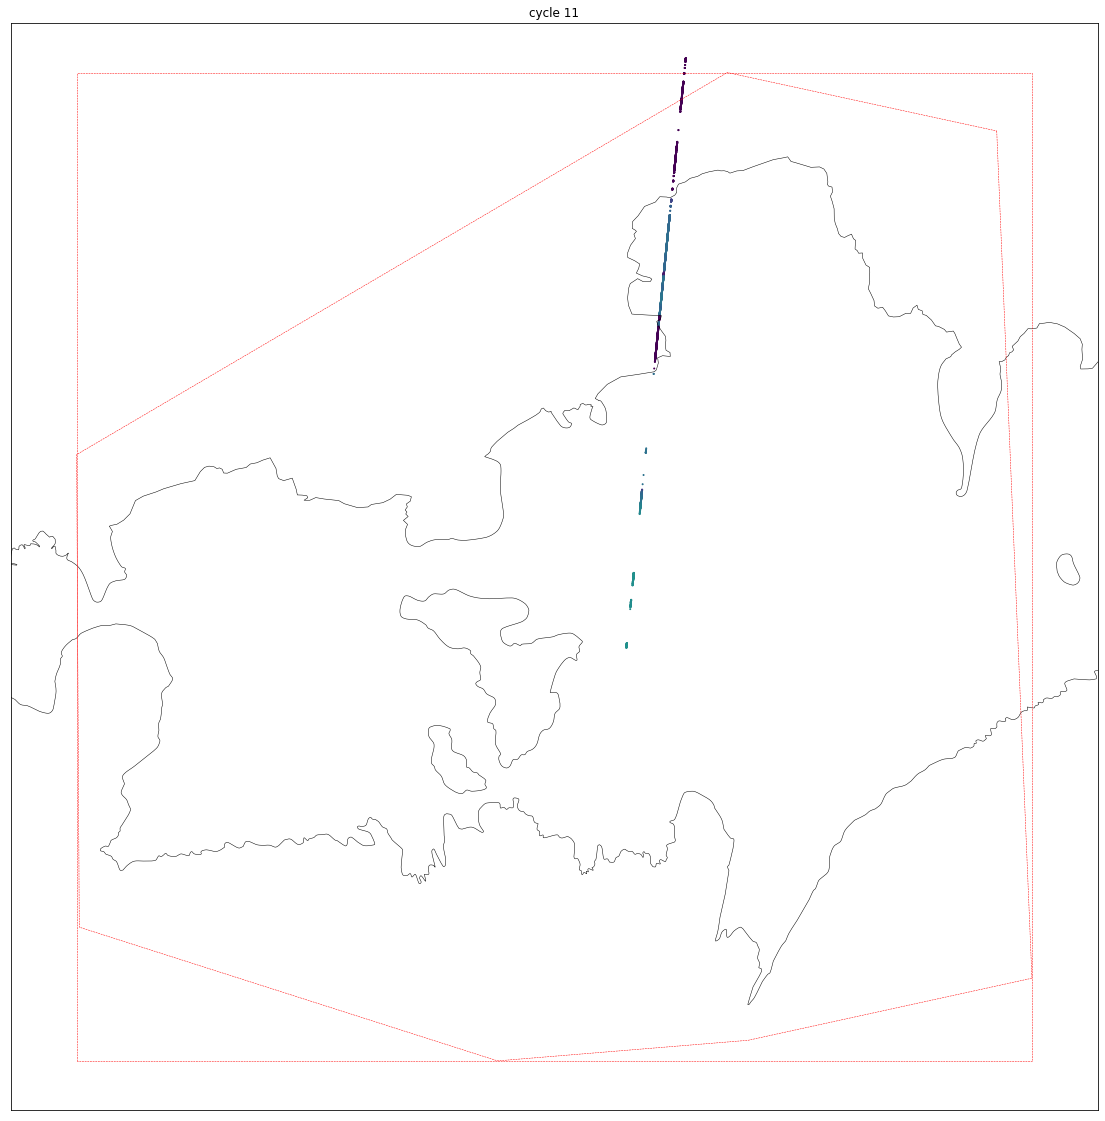

In [20]:
fig=plt.figure(figsize=(20,20))
ax1=fig.add_subplot(1,1,1)        

study_shelf_outline.boundary.plot(linestyle='-',color='k',ax=ax1,linewidth=0.5)
study_area_outline.boundary.plot(linestyle='--',color='r',ax=ax1,linewidth=0.5)

ax1.plot([study_area_xmin,study_area_xmin,study_area_xmax,study_area_xmax,study_area_xmin],\
        [study_area_ymin,study_area_ymax,study_area_ymax,study_area_ymin,study_area_ymin],\
        '--',color='r',linewidth=0.5)

for trace in range(121,122): #0,len(atl06_data_sub)):
    h_fb = np.array(atl06_data_sub["h"].iloc[trace] - atl06_data_sub["geoid"].iloc[trace])
    x = np.array(atl06_data_sub["x"].iloc[trace])
    y = np.array(atl06_data_sub["y"].iloc[trace])
    
    ax1.scatter(x,y,s=1,c=h_fb,vmin=0,vmax=100)
         
ax1.set_xlim(centerx-distbuffer,centerx+distbuffer)
ax1.set_ylim(centery-distbuffer,centery+distbuffer)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_title("cycle 11")

plt.show()

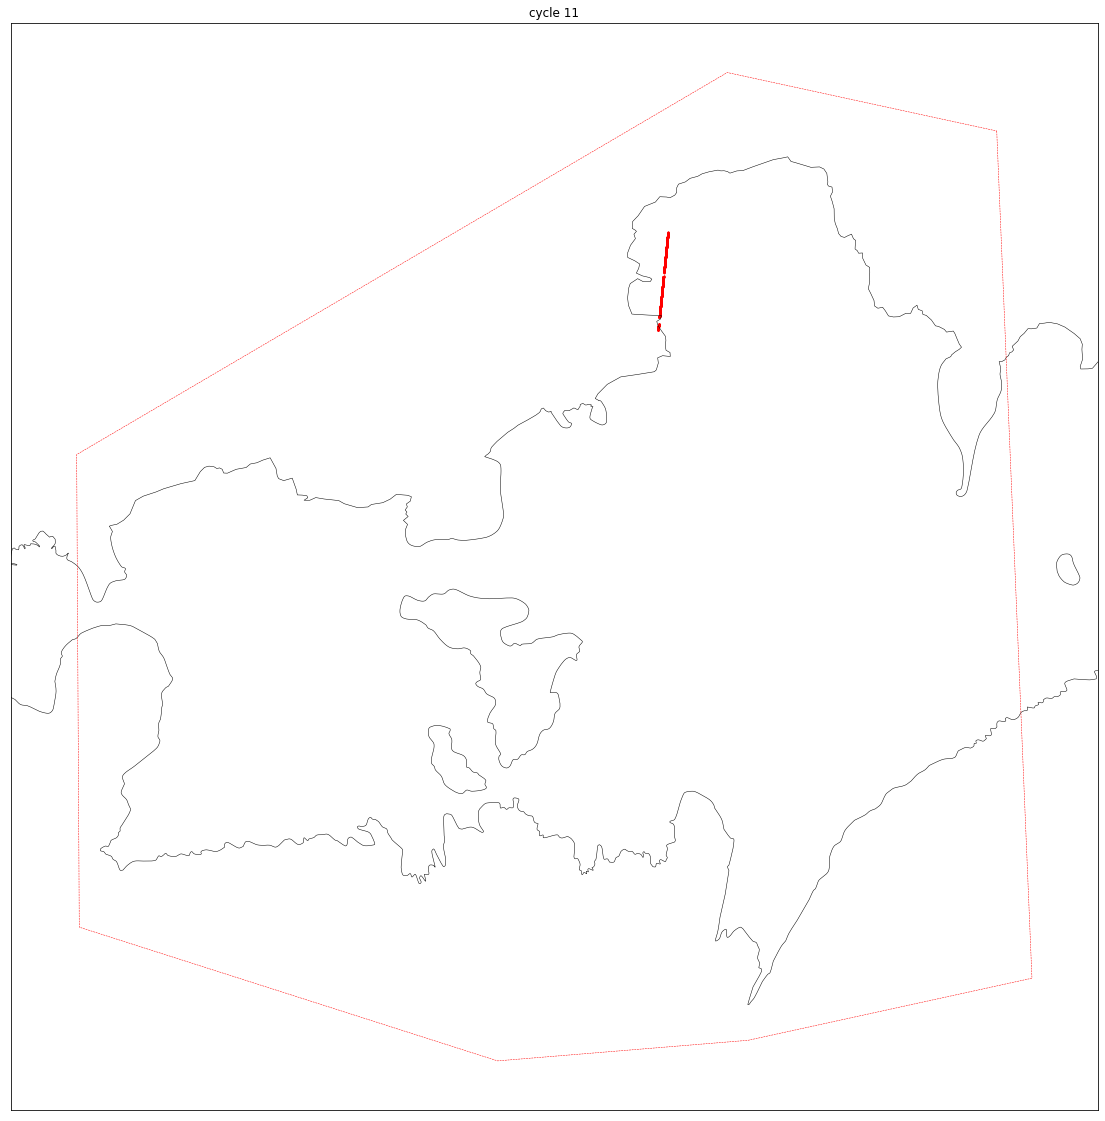

In [21]:
fig=plt.figure(figsize=(20,20))
ax3=fig.add_subplot(1,1,1)        

study_shelf_outline.boundary.plot(linestyle='-',color='k',ax=ax3,linewidth=0.5)
study_area_outline.boundary.plot(linestyle='--',color='r',ax=ax3,linewidth=0.5)

for trace_bin in range(0,len(bin_array)):
    x_mid = np.array(bin_array["x_mid"].iloc[trace_bin])
    y_mid = np.array(bin_array["y_mid"].iloc[trace_bin])
    r_bin = np.array(bin_array["bin"].iloc[trace_bin])
    
    x_min = np.array(bin_array["x_min"].iloc[trace_bin])
    y_min = np.array(bin_array["y_min"].iloc[trace_bin])
    r_bin = np.array(bin_array["bin"].iloc[trace_bin])


    ax3.scatter(x_mid[r_bin==0],y_mid[r_bin==0],s=1,c='r') #rift
    
ax3.set_xlim(centerx-distbuffer,centerx+distbuffer)
ax3.set_ylim(centery-distbuffer,centery+distbuffer)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.set_title("cycle 11")

plt.show()

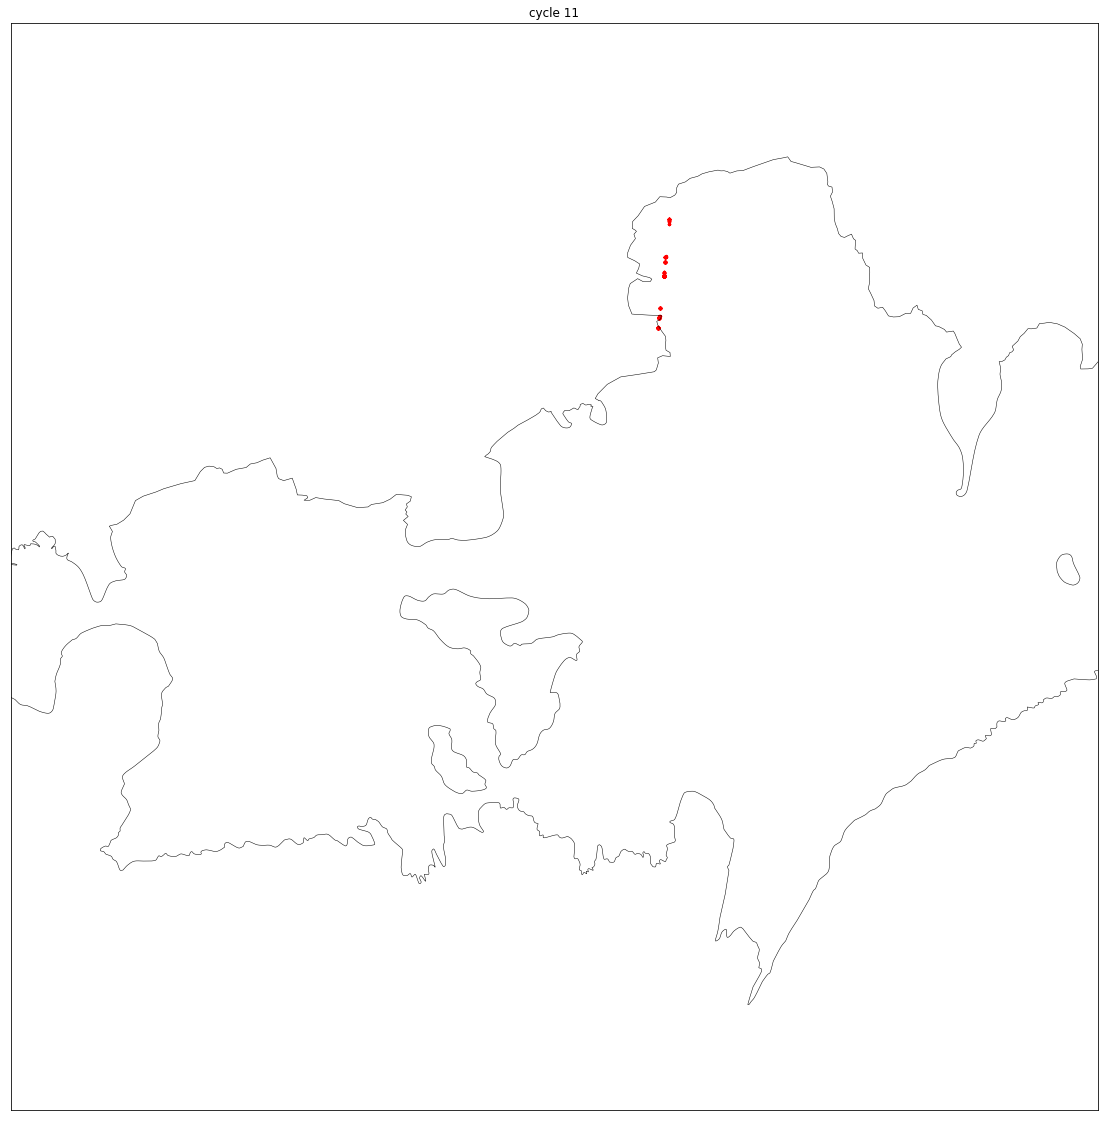

In [22]:
fig=plt.figure(figsize=(20,20))
ax3=fig.add_subplot(1,1,1)        

study_shelf_outline.boundary.plot(linestyle='-',color='k',ax=ax3,linewidth=0.5)

for trace_bin in range(0,len(bin_array)):
    x_mid = np.array(bin_array["x_mid"].iloc[trace_bin])
    y_mid = np.array(bin_array["y_mid"].iloc[trace_bin])
    r_bin = np.array(bin_array["bin"].iloc[trace_bin])
    
    x_min = np.array(bin_array["x_min"].iloc[trace_bin])
    y_min = np.array(bin_array["y_min"].iloc[trace_bin])
    r_bin = np.array(bin_array["bin"].iloc[trace_bin])

    ax3.scatter(x_min[r_bin==0],y_min[r_bin==0],s=5,c='r',alpha=0.5) #rift
    
ax3.set_xlim(centerx-distbuffer,centerx+distbuffer)
ax3.set_ylim(centery-distbuffer,centery+distbuffer)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.set_title("cycle 11")

plt.show()

[-48751.6347417  -48753.64689954 -48755.6561232  ... -51910.1215096
 -51912.11143837 -51919.13963103] [2228126.39423911 2228106.50694922 2228086.61937417 ... 2196937.38782773
 2196917.51600427 2196847.97954329]


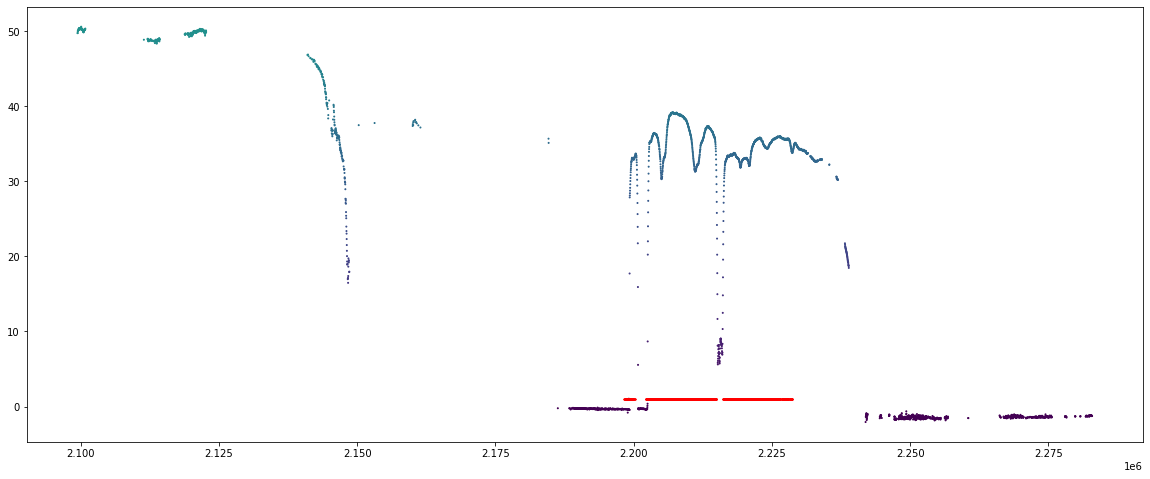

In [23]:
fig=plt.figure(figsize=(20,8))
ax1=fig.add_subplot(1,1,1)


for trace in range(121,122): #len(atl06_data_sub)):
    h_fb = np.array(atl06_data_sub["h"].iloc[trace] - atl06_data_sub["geoid"].iloc[trace])
    x = np.array(atl06_data_sub["x"].iloc[trace])
    y = np.array(atl06_data_sub["y"].iloc[trace])
    xyd = np.sqrt((x**2) + (y**2))
    
    ax1.scatter(xyd,h_fb,s=1,c=h_fb,vmin=0,vmax=100)
    
for trace_bin in range(0,len(bin_array)):
    x_mid = np.array(bin_array["x_mid"].iloc[trace_bin])
    y_mid = np.array(bin_array["y_mid"].iloc[trace_bin])
    r_bin = np.array(bin_array["bin"].iloc[trace_bin])
    xymid = np.sqrt((x_mid**2) + (y_mid**2))

    ax1.scatter(xymid[r_bin==0],np.ones(len(xymid))[r_bin==0],s=1,c='r') #rift
    print(x_mid,y_mid)

(2190000.0, 2225000.0)

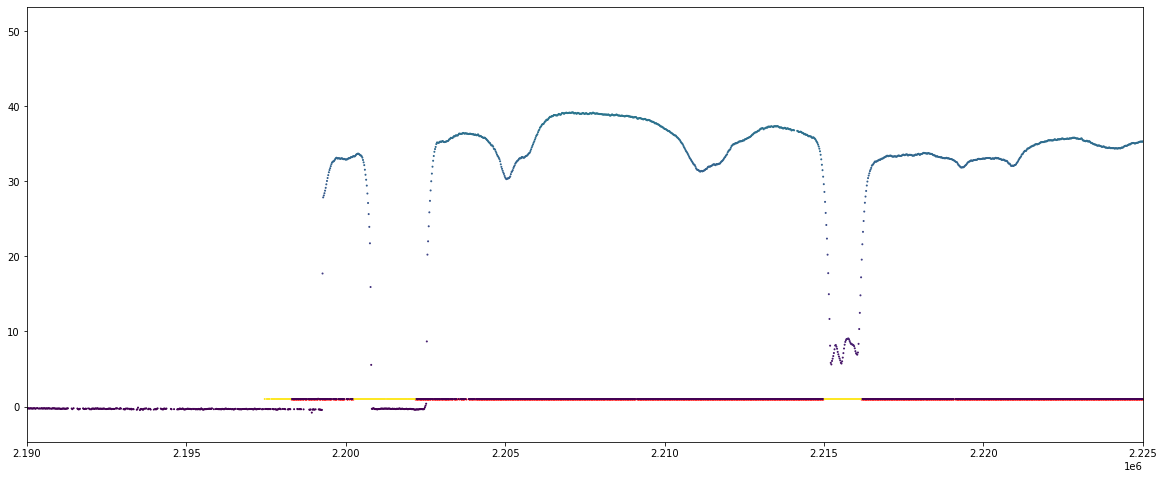

In [24]:
fig=plt.figure(figsize=(20,8))
ax1=fig.add_subplot(1,1,1)


for trace in range(121,122): #len(atl06_data_sub)):
    h_fb = np.array(atl06_data_sub["h"].iloc[trace] - atl06_data_sub["geoid"].iloc[trace])
    x = np.array(atl06_data_sub["x"].iloc[trace])
    y = np.array(atl06_data_sub["y"].iloc[trace])
    xyd = np.sqrt((x**2) + (y**2))
    
    ax1.scatter(xyd,h_fb,s=1,c=h_fb,vmin=0,vmax=100)
    
for trace_bin in range(0,len(bin_array)):
    x_mid = np.array(bin_array["x_mid"].iloc[trace_bin])
    y_mid = np.array(bin_array["y_mid"].iloc[trace_bin])
    r_bin = np.array(bin_array["bin"].iloc[trace_bin])
    xymid = np.sqrt((x_mid**2) + (y_mid**2))

    ax1.scatter(xymid[r_bin==0],np.ones(len(xymid))[r_bin==0],s=1,c='r') #rift
    ax1.scatter(xymid,np.ones(len(xymid)),s=1,c=r_bin) #rift

ax1.set_xlim([2190000,2225000])